In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gurobipy import *
import gurobipy
from gurobipy import GRB

main_df = pd.read_excel('/Users/anilturgut/Desktop/OzU/IE401/OzU-ÖrnekVeri_v2.xlsx')
df_processing_times = pd.read_excel('/Users/anilturgut/Desktop/work2.xlsx', sheet_name = 'pij2')
df_processing_times.set_index('Ptime', inplace = True)
df_return_times = pd.read_excel('/Users/anilturgut/Desktop/work2.xlsx', sheet_name = 'rij2')
df_return_times.set_index('Rtime', inplace = True)
df_deadlines = pd.read_excel('/Users/anilturgut/Desktop/work2.xlsx', sheet_name = 'dj2')
df_deadlines.set_index('Order', inplace = True)
df_return_times

,Order1,Order2,Order3,Order4,Order5,Order6,Order7,Order8,Order9,Order10,Order11,Order12,Order13,Order14,Order15
Rtime,,,,,,,,,,,,,,,
Truck1,12,8,8,12,10,9,12,13,13,11,10,11,9,10,13
Truck2,11,10,10,10,11,12,8,13,12,9,8,8,9,10,12
Truck3,7,9,8,13,12,7,10,12,9,8,8,11,12,9,9
Truck4,11,7,8,10,10,11,7,8,12,12,10,8,11,10,9
Truck5,8,9,8,9,11,7,9,8,12,8,7,12,10,9,10
Truck6,9,10,10,12,12,10,12,12,12,12,9,10,12,10,11


## Mathematical Model

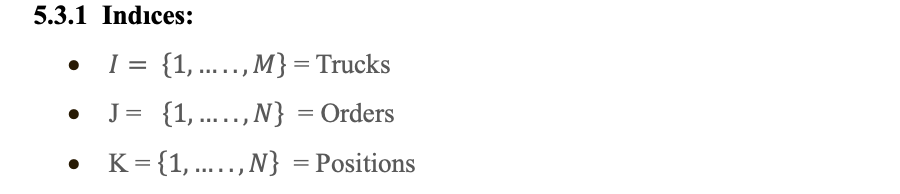

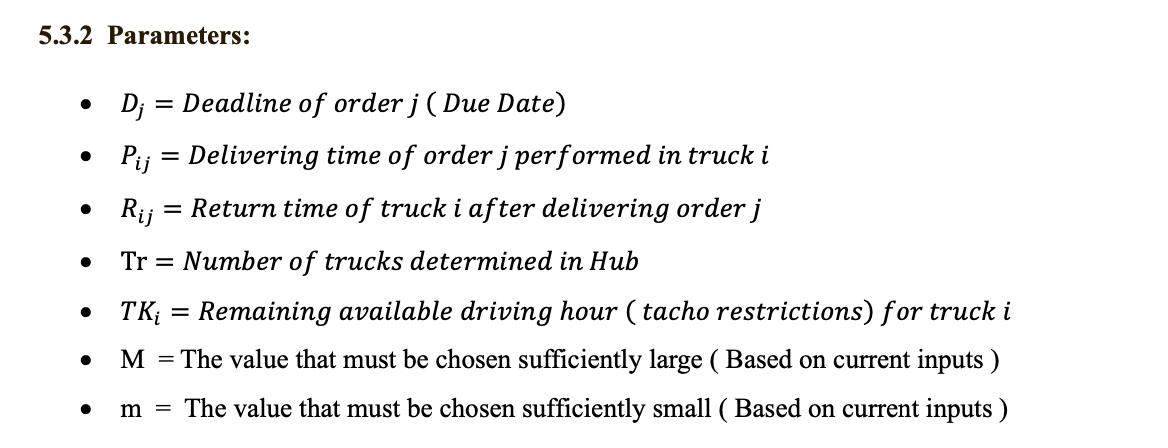

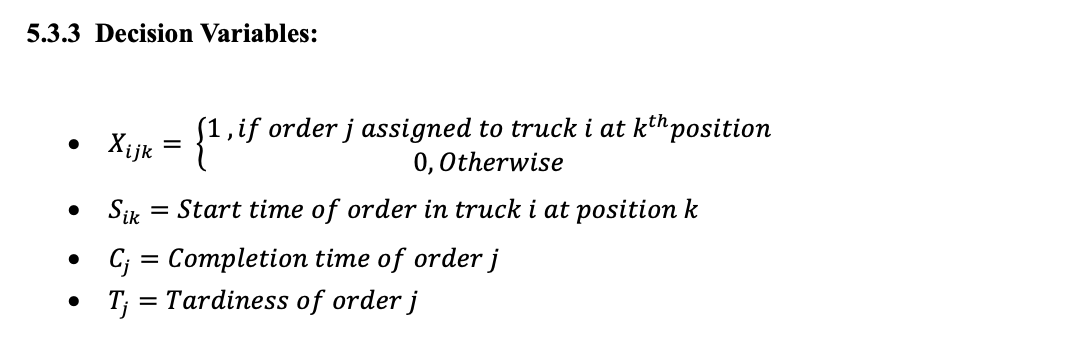

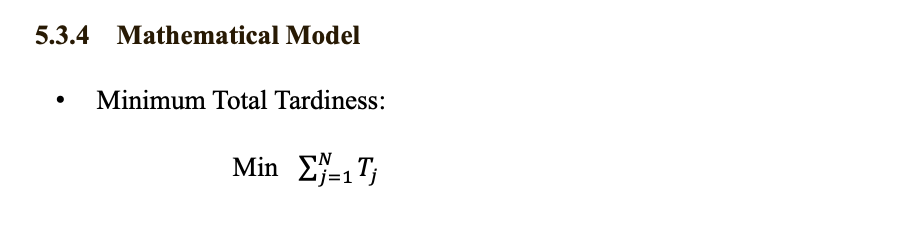

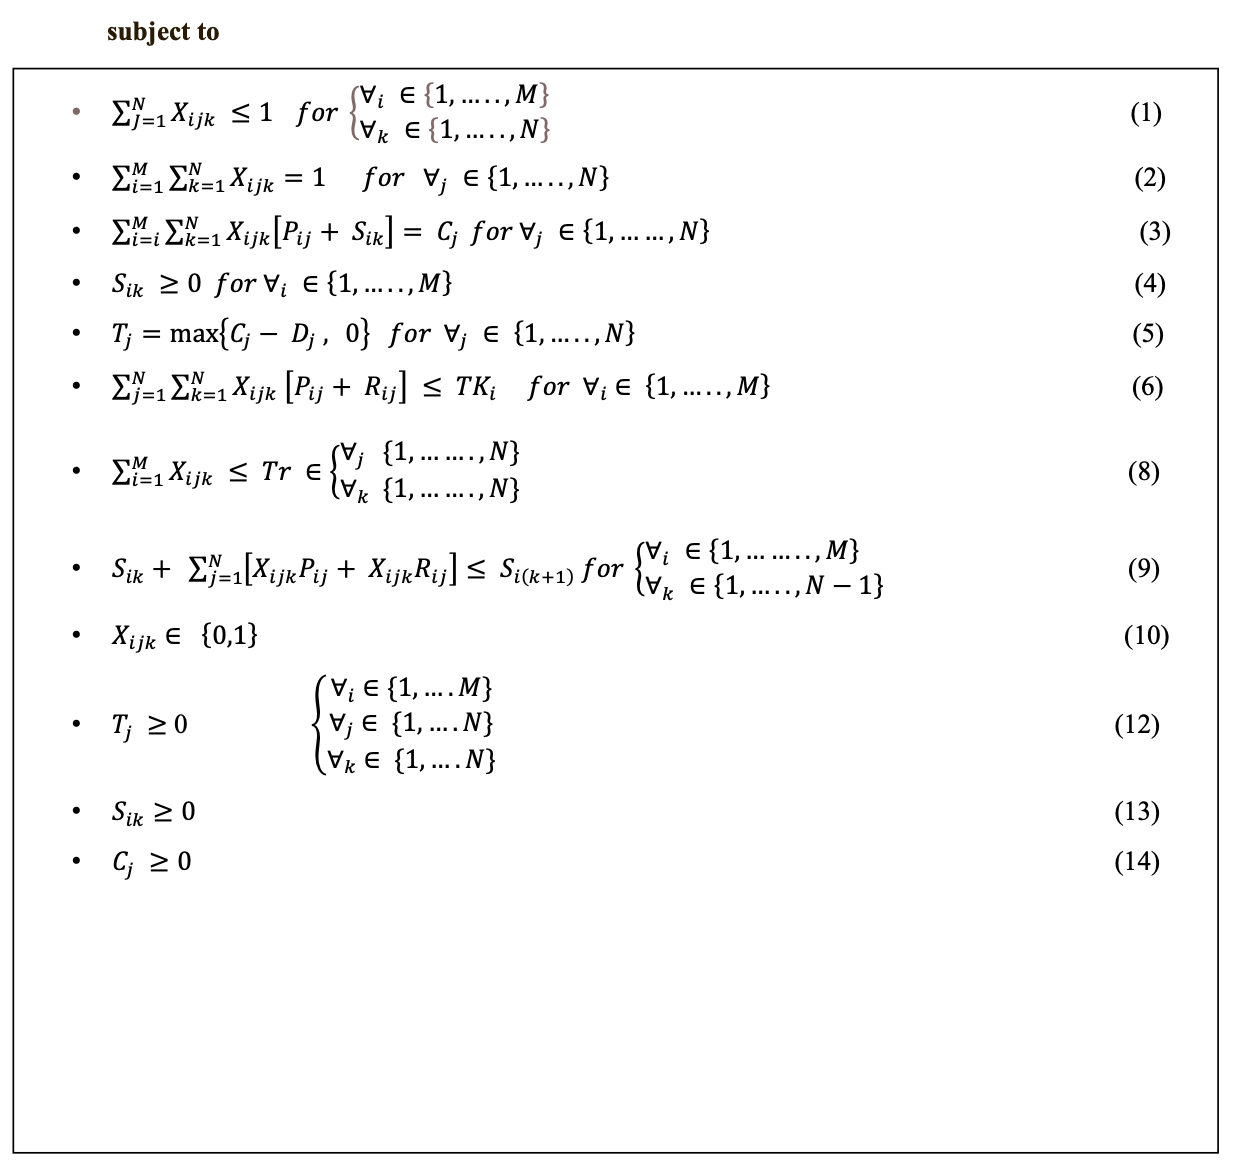

In [193]:
#Define Indices and Parameters

trucks = list(df_processing_times.index)

deadlines = df_deadlines

orders = list(deadlines.index)

TrucksInHub = int(input('Enter the maximum number of trucks in the Hub: '))

M = 100000

TKi = {
    "Truck1" : 105,
    "Truck2" : 112,
    "Truck3" : 120,
    "Truck4" : 95,
    "Truck5" : 128,
    "Truck6" : 100
}

pij = df_processing_times

rij = df_return_times

positions = []

for i in range(1,len(orders)+1):
    
    positions.append(i)
    

Enter the maximum number of trucks in the Hub: 6


In [194]:
# Initiate optimization model
model = gurobipy.Model("Ekol's Last Phase Scheduling Problem")
    
# DEFINE VARIABLES
    
# 𝑖𝑓 𝑜𝑟𝑑𝑒𝑟 𝑗 𝑎𝑠𝑠𝑖𝑔𝑛𝑒𝑑 𝑡𝑜 𝑡𝑟𝑢𝑐𝑘 𝑖 𝑎𝑡 𝑘th 𝑝𝑜𝑠𝑖𝑡𝑖𝑜𝑛
    
Xijk = model.addVars(
    trucks,
    orders,
    positions,
    vtype = gurobipy.GRB.BINARY,
    name = 'Xijk'
)

#  𝑆𝑡𝑎𝑟𝑡 𝑡𝑖𝑚𝑒 𝑜𝑓 𝑜𝑟𝑑𝑒𝑟 𝑖𝑛 𝑡𝑟𝑢𝑐𝑘 𝑖 𝑎𝑡 𝑝𝑜𝑠𝑖𝑡𝑖𝑜𝑛 𝑘
Sik = model.addVars(trucks, positions, lb = 0, vtype  = gurobipy.GRB.CONTINUOUS, name = 'Sik')

# 𝐶𝑜𝑚𝑝𝑙𝑒𝑡𝑖𝑜𝑛 𝑡𝑖𝑚𝑒 𝑜𝑓 𝑜𝑟𝑑𝑒𝑟 𝑗
Cj = model.addVars(orders, lb = 0, vtype  = gurobipy.GRB.CONTINUOUS, name = 'Cj' )

# 𝑇𝑎𝑟𝑑𝑖𝑛𝑒𝑠𝑠 𝑜𝑓 𝑜𝑟𝑑𝑒𝑟 𝑗
Tj = model.addVars(orders, vtype  = gurobipy.GRB.CONTINUOUS, name = 'Tj' )

# Auxilary Decision Variable
y = model.addVar(vtype = gurobipy.GRB.BINARY, name = 'y')



position_cons = model.addConstrs(
    (Xijk.sum(truck,'*',position) <= 1 for truck in trucks for position in positions), name = 'Position Constraint')



order_cons = model.addConstrs((Xijk.sum('*',order,'*') == 1 for order in orders), name = 'Order Constraint')


completion_cons = model.addConstrs(
    (gurobipy.quicksum((Xijk[truck,order,position] * (Sik[truck,position] + pij[order][truck]) for truck in trucks for position in positions))
    == Cj[order] for order in orders), name = 'Completion Time Cons'
)

tardy_cons = model.addConstrs(
        
    (Tj[order] == Cj[order] - deadlines['Deadline'][order] for order in orders), name = 'Tardy Variable Constraint')

ifThenForTardy_v1 = model.addConstrs(
    (Tj[order] >= -M * y for order in orders), name = 'First Tardy If-Then'
)

ifThenForTardy_v2 = model.addConstrs(
    (Tj[order] >= M *(1-y) for order in orders), name = 'Second Tardy If-Then'
)


pos_st_cons = model.addConstrs(
    (Sik.sum(truck, '*') >= 0 for truck in trucks), name = 'Non-negativite Starting Times'
)

order_cons = model.addConstrs(
    (Sik[truck,position] + gurobipy.quicksum(Xijk[truck,order,position] * (pij[order][truck] + rij[order][truck])  for order in orders)
    <= Sik[truck, position + 1] for truck in trucks for position in range(1,len(positions))), name = 'Ordering Slots'
)


posCons2 = model.addConstrs(
     (Xijk.sum(truck,'*',position) >=  Xijk.sum(truck,'*',position + 1) for truck in trucks for position in range(1,len(positions)))
)

position_init = model.addConstrs(
    (Sik[truck,1] == 0 for truck in trucks), name = 'Position Initialization'
)

truckLimit = model.addConstrs(
    
    (Xijk.sum('*','*',position) <= TrucksInHub for position in positions), name = 'Truck Limitation in Hub'
)

tachoLimit = model.addConstrs(
    (gurobipy.quicksum(Xijk[truck,order,position] * (pij[order][truck] + rij[order][truck]) for order in orders for position in positions)
    <= TKi[truck] for truck in trucks), name = 'Tacho Limitations for Trucks'
)


In [195]:
model.ModelSense = gurobipy.GRB.MINIMIZE
    
optimization_var = gurobipy.quicksum(
    Tj[order] for order in orders
)
objective = 0
objective += optimization_var

# SOLVE MODEL
model.setObjective(objective)
model.optimize()
    
model.write('IE402_Gurobi_Tardiness_V4.lp')
model.write('IE402_Gurobi_Tardiness_V4.sol')


sol = pd.DataFrame(data={"Solution": model.X}, index=model.VarName)
    

print("Total Tardiness = " + str(model.ObjVal))

sol

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (mac64[x86])
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 351 rows, 1471 columns and 9534 nonzeros
Model fingerprint: 0xcead2196
Model has 15 quadratic constraints
Variable types: 120 continuous, 1351 integer (1351 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+05]
  QMatrix range    [1e+00, 1e+00]
  QLMatrix range   [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+05]
Presolve removed 72 rows and 22 columns
Presolve time: 0.03s
Presolved: 2814 rows, 5229 columns, 16917 nonzeros
Presolved model has 2520 SOS constraint(s)
Variable types: 2619 continuous, 2610 integer (2610 binary)

Root relaxation: objective 0.000000e+00, 3616 iterations, 0.09 seconds (0.10 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Nod

,Solution
"Xijk[Truck1,Order1,1]",-0.0
"Xijk[Truck1,Order1,2]",-0.0
"Xijk[Truck1,Order1,3]",-0.0
"Xijk[Truck1,Order1,4]",-0.0
"Xijk[Truck1,Order1,5]",-0.0
...,...
Tj[Order12],2.0
Tj[Order13],0.0
Tj[Order14],4.0
Tj[Order15],0.0


In [196]:
arr_keys = []
arr_val = []
truck_arr = []
order_arr = []
position_arr = [] 
start_key = []
start_arr = []  
comp_key = []
comp_arr = [] 
process_times = []
deadline_arr = []
return_arr = []
tardy_key = []
tardy_arr = []
tacho_limits = []
for truck in trucks:
    for order in orders:
        for position in range(1,len(positions)+1):
            tempKey = 'Xijk['+truck+','+order+','+str(position)+']'
            tempVal = sol['Solution'].loc[tempKey]
            if(tempVal >= 1):
                #print(tempKey,'=',tempVal)
                temp_start = 'Sik['+truck+','+str(position)+']'
                start_key.append(temp_start)
                temp_comp = 'Cj['+order+']'
                temp_tardy = 'Tj['+order+']'
                comp_key.append(temp_comp)
                comp_arr.append(sol['Solution'].loc[temp_comp])
                process_times.append(pij[order].loc[truck])
                deadline_arr.append(deadlines['Deadline'][order])
                tardy_key.append(temp_tardy)
                tardy_arr.append(round(sol['Solution'].loc[temp_tardy]))
                #print(temp_start)
                truck_arr.append(truck)
                order_arr.append(order)
                position_arr.append(str(position))
                start_arr.append(sol['Solution'].loc[temp_start])
                arr_keys.append(tempKey)
                arr_val.append(tempVal)
                tacho_limits.append(TKi[truck])
                return_arr.append(rij[order].loc[truck])
                
            
df_bins = pd.DataFrame(columns = ['Decision Variable', 'Value'])
df_bins['Decision Variable'] = arr_keys
df_bins['Value'] = arr_val
df_bins['Truck Number'] = truck_arr
#df_bins["Truck's Tacho"] = tacho_limits
df_bins['Order Number'] = order_arr
df_bins['Position'] = position_arr
df_bins['Processing Time'] = process_times
df_bins['Return Time'] = return_arr
df_bins['Starting Keys'] = start_key
df_bins['Starting Time'] = start_arr
df_bins['Completion Keys'] = comp_key
df_bins['Completion Time'] = comp_arr
df_bins['Deadline'] = deadline_arr
df_bins['Tardy Keys'] = tardy_key
df_bins['Tardiness'] = tardy_arr
df_bins['Position'] = df_bins['Position'].astype(int)
truckList = list(df_bins['Truck Number'].unique())
df_bins_orderIndexed = df_bins.set_index('Order Number')
df_bins_positionIndexed = df_bins.set_index('Position')
df_bins

,Decision Variable,Value,Truck Number,Order Number,Position,Processing Time,Return Time,Starting Keys,Starting Time,Completion Keys,Completion Time,Deadline,Tardy Keys,Tardiness
0,"Xijk[Truck1,Order3,1]",1.0,Truck1,Order3,1,21,8,"Sik[Truck1,1]",0.0,Cj[Order3],21.0,21,Tj[Order3],0
1,"Xijk[Truck1,Order5,2]",1.0,Truck1,Order5,2,24,10,"Sik[Truck1,2]",29.0,Cj[Order5],53.0,51,Tj[Order5],2
2,"Xijk[Truck2,Order7,3]",1.0,Truck2,Order7,3,20,8,"Sik[Truck2,3]",59.0,Cj[Order7],79.0,76,Tj[Order7],3
3,"Xijk[Truck2,Order11,1]",1.0,Truck2,Order11,1,20,8,"Sik[Truck2,1]",0.0,Cj[Order11],20.0,20,Tj[Order11],0
4,"Xijk[Truck2,Order13,2]",1.0,Truck2,Order13,2,22,9,"Sik[Truck2,2]",28.0,Cj[Order13],50.0,50,Tj[Order13],0
5,"Xijk[Truck3,Order2,2]",1.0,Truck3,Order2,2,22,9,"Sik[Truck3,2]",24.0,Cj[Order2],46.0,45,Tj[Order2],1
6,"Xijk[Truck3,Order6,1]",1.0,Truck3,Order6,1,17,7,"Sik[Truck3,1]",0.0,Cj[Order6],17.0,17,Tj[Order6],0
7,"Xijk[Truck3,Order10,3]",1.0,Truck3,Order10,3,20,8,"Sik[Truck3,3]",55.0,Cj[Order10],75.0,68,Tj[Order10],7
8,"Xijk[Truck4,Order8,2]",1.0,Truck4,Order8,2,19,8,"Sik[Truck4,2]",43.0,Cj[Order8],62.0,59,Tj[Order8],3
9,"Xijk[Truck4,Order9,1]",1.0,Truck4,Order9,1,31,12,"Sik[Truck4,1]",0.0,Cj[Order9],31.0,31,Tj[Order9],0


In [188]:
df_bins_positionIndexed

,Decision Variable,Value,Truck Number,Order Number,Processing Time,Return Time,Starting Keys,Starting Time,Completion Keys,Completion Time,Deadline,Tardy Keys,Tardiness
Position,,,,,,,,,,,,,
1,"Xijk[Truck1,Order3,1]",1.0,Truck1,Order3,21,8,"Sik[Truck1,1]",0.0,Cj[Order3],21.0,21,Tj[Order3],0
2,"Xijk[Truck1,Order5,2]",1.0,Truck1,Order5,24,10,"Sik[Truck1,2]",29.0,Cj[Order5],53.0,51,Tj[Order5],2
3,"Xijk[Truck2,Order7,3]",1.0,Truck2,Order7,20,8,"Sik[Truck2,3]",59.0,Cj[Order7],79.0,76,Tj[Order7],3
1,"Xijk[Truck2,Order11,1]",1.0,Truck2,Order11,20,8,"Sik[Truck2,1]",0.0,Cj[Order11],20.0,20,Tj[Order11],0
2,"Xijk[Truck2,Order13,2]",1.0,Truck2,Order13,22,9,"Sik[Truck2,2]",28.0,Cj[Order13],50.0,50,Tj[Order13],0
2,"Xijk[Truck3,Order2,2]",1.0,Truck3,Order2,22,9,"Sik[Truck3,2]",24.0,Cj[Order2],46.0,45,Tj[Order2],1
1,"Xijk[Truck3,Order6,1]",1.0,Truck3,Order6,17,7,"Sik[Truck3,1]",0.0,Cj[Order6],17.0,17,Tj[Order6],0
3,"Xijk[Truck3,Order10,3]",1.0,Truck3,Order10,20,8,"Sik[Truck3,3]",55.0,Cj[Order10],75.0,68,Tj[Order10],7
2,"Xijk[Truck4,Order8,2]",1.0,Truck4,Order8,19,8,"Sik[Truck4,2]",43.0,Cj[Order8],62.0,59,Tj[Order8],3


In [197]:
def tacho_update(df, position, tacho):
    if position == 1:
        return (tacho - (df['Completion Time'].loc[position] - df['Starting Time'].loc[position]))
    elif position == 2:
        return (tacho - (df['Completion Time'].loc[position] - df['Starting Time'].loc[position - 1]))
    elif position == 3:
        return (tacho - (df['Completion Time'].loc[position] - df['Starting Time'].loc[position - 2]))
    elif position == 4:
        return (tacho - (df['Completion Time'].loc[position] - df['Starting Time'].loc[position - 3]))
    else:
        return (tacho - (df['Completion Time'].loc[position] - df['Starting Time'].loc[position - 4]))

def positionLister(truck):
    positionForTruck = []
    for ind in range(len(df_bins)):
        if (df_bins['Truck Number'].iloc[ind] == truck):
            positionForTruck.append(df_bins['Position'].iloc[ind])
    positionForTruck = [int(i) for i in positionForTruck]
    positionForTruck.sort()
    return positionForTruck

tacho_array = []
position_array = []
for truck in truckList:
    temp_arr = []
    temp_arr2 = []
    temp_df = df_bins_positionIndexed.groupby('Truck Number').get_group(truck)
    temp_position = positionLister(truck)
    for index in temp_position:
        temp_arr.append(round(tacho_update(temp_df, index, TKi[truck]),1))
        temp_arr2.append(index)
    tacho_array.append(temp_arr)
    position_array.append(temp_arr2)
    

df_tacho = df_bins[['Truck Number','Order Number','Position']]
df_tacho.insert(1,"Starting Tacho's",tacho_limits)
df_tacho['Remaining Tacho'] = 'tbd'

df_tacho_final = pd.DataFrame()
for i in range(len(position_array)):
    truckName = truckList[i]
    temp_df = df_tacho.groupby('Truck Number').get_group(truckName)
    temp_df = temp_df.set_index('Position')
    for j in range(len(position_array[i])):
        temp_df['Remaining Tacho'].loc[j+1] = tacho_array[i][j]
        
    df_tacho_final = pd.concat([df_tacho_final, temp_df], axis = 0)
df_tacho_final.reset_index(inplace = True)
df_tacho_final = df_tacho_final[['Truck Number', "Starting Tacho's", "Order Number","Position","Remaining Tacho"]]
df_tacho_final
    

/Users/anilturgut/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/anilturgut/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,Truck Number,Starting Tacho's,Order Number,Position,Remaining Tacho
0,Truck1,105,Order3,1,84
1,Truck1,105,Order5,2,52
2,Truck2,112,Order7,3,33
3,Truck2,112,Order11,1,92
4,Truck2,112,Order13,2,62
5,Truck3,120,Order2,2,74
6,Truck3,120,Order6,1,103
7,Truck3,120,Order10,3,45
8,Truck4,95,Order8,2,33
9,Truck4,95,Order9,1,64


In [153]:
df_bins_orderIndexed

,Decision Variable,Value,Truck Number,Position,Processing Time,Return Time,Starting Keys,Starting Time,Completion Keys,Completion Time,Deadline,Tardy Keys,Tardiness
Order Number,,,,,,,,,,,,,
Order3,"Xijk[Truck1,Order3,1]",1.0,Truck1,1,13,4,"Sik[Truck1,1]",0.0,Cj[Order3],13.0,11,Tj[Order3],2
Order2,"Xijk[Truck2,Order2,1]",1.0,Truck2,1,10,2,"Sik[Truck2,1]",0.0,Cj[Order2],10.0,10,Tj[Order2],0
Order5,"Xijk[Truck2,Order5,2]",1.0,Truck2,2,12,4,"Sik[Truck2,2]",12.0,Cj[Order5],24.0,23,Tj[Order5],1
Order1,"Xijk[Truck3,Order1,1]",1.0,Truck3,1,5,3,"Sik[Truck3,1]",0.0,Cj[Order1],5.0,4,Tj[Order1],1
Order4,"Xijk[Truck3,Order4,2]",1.0,Truck3,2,17,3,"Sik[Truck3,2]",8.0,Cj[Order4],25.0,22,Tj[Order4],3


In [198]:
completion_times = list(df_bins['Completion Time'])
return_times = list(df_bins['Return Time'])

max_completion_time = int(max(completion_times))
max_return_time = int(max(return_times))


time_slot = [x for x in range(0,max_completion_time + max_return_time)]
df_schedule = pd.DataFrame(columns = time_slot, index = orders)

for order in orders:
    for col in df_schedule.columns:
        df_schedule[col].loc[order] = '-'
truck_arr2 = []
position_arr2 = []
for order in orders:
    for col in df_schedule.columns:
        if round(df_bins_orderIndexed['Starting Time'].loc[order]) == col:
            for time in range(df_bins_orderIndexed['Processing Time'].loc[order]):
                df_schedule[col + time].loc[order] = 'PRO'
            truck_arr2.append(df_bins_orderIndexed['Truck Number'].loc[order])
            position_arr2.append(df_bins_orderIndexed['Position'].loc[order])
for order in orders:
    for col in df_schedule.columns:
        if round(df_bins_orderIndexed['Completion Time'].loc[order]) == col:
            for time in range(df_bins_orderIndexed['Return Time'].loc[order]):
                df_schedule[col + time].loc[order] = 'RET'
                
df_schedule.reset_index(inplace = True)
df_schedule.rename(columns = {'index':'Order'}, inplace = True)
df_schedule.insert(0,'Truck',truck_arr2)
df_schedule.insert(1,'Position',position_arr2)
df_schedule.set_index('Order', inplace = True)
df_schedule['Position'] = df_schedule['Position'].astype(int)
df_schedule.sort_values('Position', inplace = True)
df_schedule2 = df_schedule.reset_index()

#truckList = list(df_bins['Truck Number'].unique())

df_final = pd.DataFrame()

for truck in truckList:
    
    df_temp = df_schedule2.groupby('Truck').get_group(truck)
    df_final = pd.concat([df_final, df_temp], axis=0)
df_final['Position'] = df_final['Position'].astype(int)
df_final_schedule = df_final.set_index('Truck')

In [199]:
df_final_schedule

,Order,Position,0,1,2,3,4,5,6,7,...,82,83,84,85,86,87,88,89,90,91
Truck,,,,,,,,,,,,,,,,,,,,,
Truck1,Order3,1,PRO,PRO,PRO,PRO,PRO,PRO,PRO,PRO,...,-,-,-,-,-,-,-,-,-,-
Truck1,Order5,2,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Truck2,Order11,1,PRO,PRO,PRO,PRO,PRO,PRO,PRO,PRO,...,-,-,-,-,-,-,-,-,-,-
Truck2,Order13,2,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Truck2,Order7,3,-,-,-,-,-,-,-,-,...,RET,RET,RET,RET,RET,-,-,-,-,-
Truck3,Order6,1,PRO,PRO,PRO,PRO,PRO,PRO,PRO,PRO,...,-,-,-,-,-,-,-,-,-,-
Truck3,Order2,2,-,-,-,-,-,-,-,-,...,-,-,-,-,-,-,-,-,-,-
Truck3,Order10,3,-,-,-,-,-,-,-,-,...,RET,-,-,-,-,-,-,-,-,-
Truck4,Order9,1,PRO,PRO,PRO,PRO,PRO,PRO,PRO,PRO,...,-,-,-,-,-,-,-,-,-,-


In [200]:
writer = pd.ExcelWriter('/Users/anilturgut/Desktop/OUTPUTS/V4/tardinessOutputV4_from_Python.xlsx', engine = 'xlsxwriter')

sol.to_excel(writer, sheet_name = 'Main Output')
df_bins.to_excel(writer, sheet_name = 'General Dataframe')
df_tacho_final.to_excel(writer, sheet_name = 'Tacho Information')
df_final_schedule.to_excel(writer, sheet_name = 'Schedule From Python')

writer.save()